<img align="right" style="max-width: 200px; height: auto" src="hsg_logo.png">

# Lab 08 - "Linear Regression"

Introduction to AI and ML, University of St. Gallen, Autumn Term 2020

The lab environment of the **"Machine Learning"** course is powered by Jupyter Notebooks (https://jupyter.org), which allows one to perform a great deal of data analysis and statistical validation. In this lab, we will build our first **Linear Regression** model. With it, we aim to use the stock price values of 10 Swiss stocks to predict the **Swiss Market Index - SMI** stock price for the following day. Recall that Linear Regression belongs to Supervised Learning - where labels are known:

<img align="center" style="max-width: 600px; height: auto" src="ml_types.png">

(Courtesy: Intro to AI & ML lecture, Prof. Dr. Borth, University of St. Gallen)

Regression has different applications such as:
>- Prediction
>- Forecasting
>- Trends identification
>- Modelling dependency
>- Data smoothing
>- Hypothesis testing

## 1. Lab Objectives

After today's lab, you should be able to:

> 1. Understand how a **Linear Regression** model can be trained and evaluated.
> 2. Gather financial data and prepare `DataFrames` that can be used for training ML algorithms.
> 3. Train and evaluate **Regression models** using Python's `scikit-learn` library.
> 4. Understand how to **evaluate** and **interpret** the regression results.

<img align="center" style="max-width: 600px; height: auto" src="architecture_pipeline.png">

Basic Linear Regression architecture - from a dataset with features and a target variable, find the relationship between the features and the target by considering the target to be a weighted sum of the features. Use that formula to then predict unseen observations.

Before we start let's watch a motivational video:

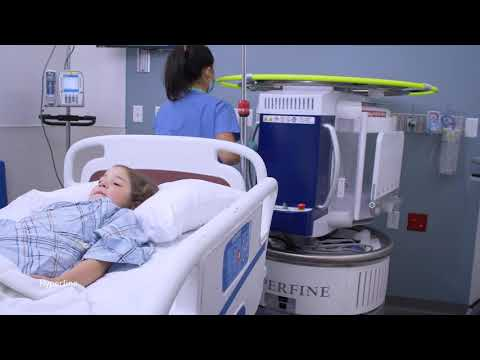

In [215]:
from IPython.display import YouTubeVideo
#NVIDIA: "A New Era of Healthcare with AI | I AM AI"
YouTubeVideo('qlNbC88SU7o', width=800, height=600)

## 2. Setup of the Analysis Environment

We need to import a couple of Python libraries that allow for data analysis and data visualization. In this lab will use the `Pandas`, `Numpy`, `Scikit-Learn`, `Matplotlib` and the `Seaborn` library. Let's import the libraries by the execution of the statements below:

In [216]:
# import the datetime, numpy and pandas data science library
import datetime as dt
import pandas as pd
import numpy as np

# import pandas up-to-date remote data access library to get data
import pandas_datareader as dr

# import data pre-processing libraries
from sklearn.model_selection import train_test_split

# import Linear Regression library
from sklearn.linear_model import LinearRegression

# import sklearn evaluation library
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix

# import matplotlib data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

Although the **MS Azure** as well as the **Google Colab** environment come with a lot of pre-installed libraries, sometimes a needed library might not be available. Therefore, you may want to install libraries directly within an individual notebook. Please note, libraries installed from the notebook apply only to the current server session. Library installations aren't persistent once the server is shut down.

In general, libraries in Python can be installed using the shell **pip** command within code cells. Any command that works at the command-line can be used in Jupyter Notebooks by prefixing it with the `!` character. Let's give it a try and install the `pandas_datareader` python library.

You will be asked to restart the Colab runtime. You can do this under `Runtime`. Once restarted, you should be able to successfully run the lab again and access `pandas_datareader`.

If the following libraries (`pandas` and `pandas_datareader`) are not yet downloaded, please un-comment the following lines and run them (then restart runtime and run all). If they are, you may leave these lines commented.

In [217]:
#!pip3 install pandas_datareader --ignore-installed
#!pip3 install pandas==1.0.0

Set random seed of all our experiments - this insures reproducibility.

In [218]:
random_seed = 42

Enable inline Jupyter notebook plotting:

In [219]:
%matplotlib inline

Use the 'Seaborn' plotting style in all subsequent visualizations:

In [220]:
plt.style.use('seaborn')

## 3. Linear Regression

### 3.1 Dataset Assembling and Assessment

#### 3.1.1 Data Download and Dataset Creation

In this simple regression task, we will attempt to look at the stock prices on day $t$ of large Swiss firms that appear on the **Swiss Market Index (SMI)**, to predict the **SMI** stock price on day $t + 1$. We will thus hope that our **Linear Regression** algorithm can infer the **SMI** stock price based on the stock prices of these firms from the previous day.

<img align="center" style="max-width: 600px; height: auto" src="swiss_flag.png">

To get our stock prices, we will access financial data using panda's `DataReader`. We also need to chose a timeframe in which to analyze our data. Let's say we want to use data from September 1st, 2012 to November 10th, 2020. We shall specify both the `start` and `end` date of the data download:

In [221]:
start_date = dt.datetime(2012, 9, 1)
end_date = dt.datetime(2020, 11, 10)

In this tutorial, we will work with 10 stocks that appear on the Swiss Market Index - the **SMI**. Based on their adjusted closing prices for the days in our timeframe (September 2012 to November 2020), we will try to predict the **SMI Stock Price** for the following day.

Here is an example of what happens when we download the data for one of these stocks. Download the daily **Nestlé** (ticker symbol: NESN.SW) stock data using the `DataReader` object of the `Pandas` data science library: 

In [222]:
nestle_data = dr.data.DataReader('NESN.SW', data_source='yahoo', start=start_date, end=end_date)

Note that we use *yahoo* as our source for financial data. Different sources are available.

We can also verify that our `nestle_data` has been returned as a Pandas `DataFrame` by the `DataReader` object:

In [223]:
type(nestle_data)

pandas.core.frame.DataFrame

Let's examine the last five rows from this small Nestlé dataset:

In [224]:
nestle_data.tail(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-04,108.720001,105.820000,105.900002,108.459999,5086795.0,108.459999
2020-11-05,108.800003,106.779999,108.459999,107.160004,5152130.0,107.160004
2020-11-06,106.980003,105.779999,106.900002,106.500000,3927009.0,106.500000
2020-11-09,108.940002,104.900002,107.300003,105.459999,9209793.0,105.459999
2020-11-10,105.959999,103.379997,104.559998,104.459999,10349808.0,104.459999


As can be seen, the `DataReader` presents the data in a pretty neat way. For each trading day (you will observe that week-ends do not appear in the `Date` column), we get 6 numbers. `High` and `Low` refer to the highest and lowest prices the stock has reached on the day, `Open` and `Close` are the prices at which the stocks were first and last traded on the day, `Volume` refers to the number of shares traded that day and lastly, `Adj Close` is the closing price adjusted for any corporate actions (stock splits, dividends ...).

Let's list the ticker symbols for the 10 stocks we will look at. These stocks are (in order) `Nestlé`, `Novartis`, `Hoffmann-La Roche`, `Zurich Insurance Group`, `ABB`, `UBS`, `Lonza`, `Givaudan`, `Richemont` and `Sika`.

In [225]:
swiss_stocks = ['NESN.SW', 'NOVN.SW', 'ROG.SW', 'ZURN.SW', 'ABBN.SW', 'UBSG.SW', 'LONN.SW', 'GIVN.SW', 'CFR.SW', 'SIKA.SW']

Let's download that information for all 10 stocks we will use in our Regression:

In [226]:
swiss_stocks_data = dr.data.DataReader(swiss_stocks, data_source='yahoo', start=start_date, end=end_date)

Inspect the first lines (dates):

In [227]:
swiss_stocks_data.head(5)

Attributes  Adj Close                         ...   Volume                     
Symbols       NESN.SW    NOVN.SW      ROG.SW  ...  GIVN.SW     CFR.SW   SIKA.SW
Date                                          ...                              
2012-09-03  47.284203  36.802326  134.912048  ...  13336.0  1190816.0  216240.0
2012-09-04  46.653221  36.444069  133.522797  ...  22482.0  1856051.0  308160.0
2012-09-05  47.126453  36.900036  134.757706  ...  15271.0  2429504.0  136980.0
2012-09-06  47.441944  37.193157  137.073120  ...  15808.0  1567961.0  118380.0
2012-09-07  46.732086  36.867470  137.304657  ...  28875.0  2554122.0  510660.0

[5 rows x 60 columns]

Now, we shall select only the `Adj Close` prices for each stock, as it is based on that price that we will attempt to predict the **SMI**. We create a new dataset containing only that column:

In [228]:
swiss_stocks = swiss_stocks_data['Adj Close']

In [229]:
swiss_stocks.shape

(2051, 10)

Let's look at the `DataFrame` we just created:

In [230]:
swiss_stocks

Symbols,NESN.SW,NOVN.SW,ROG.SW,ZURN.SW,ABBN.SW,UBSG.SW,LONN.SW,GIVN.SW,CFR.SW,SIKA.SW
Date,,,,,,,,,,
2012-09-03,47.284203,36.802326,134.912048,141.471893,12.537480,7.146395,35.830795,724.118713,50.499882,-0.001031
2012-09-04,46.653221,36.444069,133.522797,140.670181,12.364912,7.033172,35.424496,715.336670,49.784466,-0.001011
2012-09-05,47.126453,36.900036,134.757706,141.595245,12.349907,7.246297,35.188755,720.126831,50.541958,-0.001016
2012-09-06,47.441944,37.193157,137.073120,143.877045,12.845104,7.579308,36.245255,725.316223,51.467796,-0.001034
2012-09-07,46.732086,36.867470,137.304657,144.925446,13.250263,7.765793,36.627247,718.929199,53.235294,-0.001052
...,...,...,...,...,...,...,...,...,...,...
2020-11-04,108.459999,77.050003,323.100006,321.100006,23.500000,11.252357,610.799988,3925.000000,61.480000,239.800003
2020-11-05,107.160004,76.510002,320.899994,324.000000,23.840000,11.427416,622.200012,3924.000000,63.400002,243.500000
2020-11-06,106.500000,76.379997,320.700012,322.299988,24.030001,11.417690,617.200012,3940.000000,69.040001,244.000000


Looks good! Now let's move on to the **SMI** stock price data - which is our **target**, what we will aim to be able to predict later on.

Our goal is to create a dataset in which for each given date, you have the adjusted closing prices of our ten stocks for the day and the **SMI** price for the next day (we want our model to be able to predict the **SMI** stock price for the next day, not the current day as this would have no use). To that end, we will have to shift our **SMI** price by one day in our final dataset. Because of that shift, we will have a missing value for the last day of the **SMI** column if we use the same end date for that than we used for our stock prices. Thus, we will simply make our end date one day later for the **SMI** data.

In [231]:
end_date_next_day = dt.datetime(2020, 11, 11) #November 11th, 2020

Let's now download the **SMI** stock prices!

In [232]:
smi_data = dr.data.DataReader('^SSMI', data_source='yahoo', start=start_date, end=end_date_next_day)

Inspect the first 5 rows:

In [233]:
smi_data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-05,10381.019531,10268.910156,10333.610352,10306.349609,66638300,10306.349609
2020-11-06,10350.379883,10221.650391,10263.309570,10322.570312,58135700,10322.570312
2020-11-09,10644.219727,10350.049805,10405.969727,10417.990234,117789800,10417.990234
2020-11-10,10422.669922,10310.419922,10389.839844,10360.690430,119435300,10360.690430
2020-11-11,10558.629883,10367.219727,10369.429688,10532.269531,67520600,10532.269531


Great! Based on our different end dates, the `swiss_stocks` DataFrame should have one less row (trading day) than the `smi_data` DataFrame. Let's check the last row of each sub-dataset to verify if the `smi_data` indeed ends one day later:

In [234]:
swiss_stocks.tail(1)

Symbols,NESN.SW,NOVN.SW,ROG.SW,ZURN.SW,ABBN.SW,UBSG.SW,LONN.SW,GIVN.SW,CFR.SW,SIKA.SW
Date,,,,,,,,,,
2020-11-10,104.459999,77.32,305.25,340.899994,24.84,12.137374,576.200012,3670.0,75.459999,230.0


In [235]:
smi_data.tail(1)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-11,10558.629883,10367.219727,10369.429688,10532.269531,67520600,10532.269531


Indeed it does! Regarding the columns, 10 make sense for the `swiss_stocks` DataFrame, and we have our 6 figures for the `smi_data`. We will only select the `Adj Close` column when we merge the two DataFrames, as this is what we will want to predict later on.

Let's also verify that both sets are DataFrames:

In [236]:
print(type(smi_data))
print(type(swiss_stocks))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


Now we can merge the two datasets. We will create a new DataFrame `df` that contains our stocks, and only the `Adj Close` column from the **SMI** data. To merge the two sets, we will use the `.concat()` method. By the same occasion, we shift the **SMI** price by one day, so that for a given date (row), we will have our stock prices for the day and the **SMI** price for the **next** day. This can be done using the `.shift()` method.

Lastly, we rename the column from the **SMI** data (which will be taken as `Adj Close`) to `SMI t+1`.

In [237]:
# Concatenate our the swiss_stocks DataFrame and the 'Adj Close' column from the smi_data DataFrame along the columns axis
# Note that we applied the .shift() method on the smi_data column to shift it by a period of -1 to get the price for the next day
df = pd.concat([swiss_stocks, smi_data['Adj Close'].shift(periods=-1)], axis = 1)

# Drop the last line of the dataset (2.9.2020), as we have no values there anymore, just NaNs
df.drop(df.tail(1).index,inplace=True)

# Rename the SMI column to 'SMI t+1'. inplace = True returns a new DataFrame, not a copy of the previous one
df.rename(columns = {'Adj Close':'SMI t+1'}, inplace=True)

Inspect the DataFrame:

In [238]:
df

,NESN.SW,NOVN.SW,ROG.SW,ZURN.SW,ABBN.SW,UBSG.SW,LONN.SW,GIVN.SW,CFR.SW,SIKA.SW,SMI t+1
Date,,,,,,,,,,,
2012-09-03,47.284203,36.802326,134.912048,141.471893,12.537480,7.146395,35.830795,724.118713,50.499882,-0.001031,6362.819824
2012-09-04,46.653221,36.444069,133.522797,140.670181,12.364912,7.033172,35.424496,715.336670,49.784466,-0.001011,6425.200195
2012-09-05,47.126453,36.900036,134.757706,141.595245,12.349907,7.246297,35.188755,720.126831,50.541958,-0.001016,6527.870117
2012-09-06,47.441944,37.193157,137.073120,143.877045,12.845104,7.579308,36.245255,725.316223,51.467796,-0.001034,6537.319824
2012-09-07,46.732086,36.867470,137.304657,144.925446,13.250263,7.765793,36.627247,718.929199,53.235294,-0.001052,6507.870117
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-04,108.459999,77.050003,323.100006,321.100006,23.500000,11.252357,610.799988,3925.000000,61.480000,239.800003,10306.349609
2020-11-05,107.160004,76.510002,320.899994,324.000000,23.840000,11.427416,622.200012,3924.000000,63.400002,243.500000,10322.570312
2020-11-06,106.500000,76.379997,320.700012,322.299988,24.030001,11.417690,617.200012,3940.000000,69.040001,244.000000,10417.990234


A useful thing to do here is to verify whether we have any missing values in our `DataFrame`. To do so, we use pandas DataFrame's `.isna()` and `.any()` methods to detect missing values over the set.

In [239]:
df[df.isna().any(axis=1)]

,NESN.SW,NOVN.SW,ROG.SW,ZURN.SW,ABBN.SW,UBSG.SW,LONN.SW,GIVN.SW,CFR.SW,SIKA.SW,SMI t+1
Date,,,,,,,,,,,
2020-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10325.44043


For some reason, we have missing values for our 10 stock prices on September 18th, 2020. Let's then simply drop that row of data.

In [240]:
df.drop(pd.Timestamp('2020-09-18'), inplace=True)

If we take the first row, September 3rd 2012, you will see that the value in the `SMI t+1` column is `6362.819824`. If you go back to when we showed the `smi_data`, that was the **SMI** price for September 4th 2012. We thus successfully shifted our numbers, in our aim to predict the **SMI** price for the next day.

Great! That closes our dataset preparation sub-chapter!

#### 3.1.2 Data Assessment and Visualization

Now that we've downloaded our data and created a cool dataset to work with, let's get to know it a bit better.

First, let's visualize the evolutions of our 10 stocks:

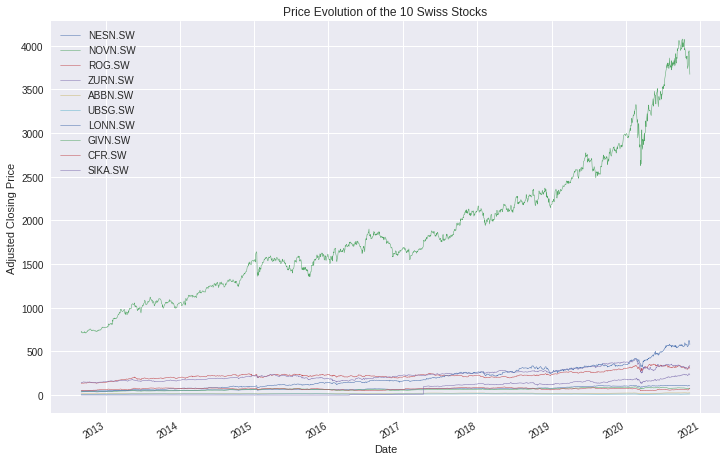

In [241]:
# Define the plot (plot all lines except SMI t+1)
ax = df.drop(['SMI t+1'], axis=1).plot(linewidth=0.5, figsize=(12,8))
# Title
ax.set_title('Price Evolution of the 10 Swiss Stocks')
# ylabel
ax.set_ylabel('Adjusted Closing Price');

Wow! The `GIVN.SW` (Givaudan) stock price is so much higher than our other stocks that it makes it difficult to visualize them in detail. We can also see the the Givaudan stock price increased spectacularly! About five-fold. If we remove it from our plot, we can better see our other stocks:

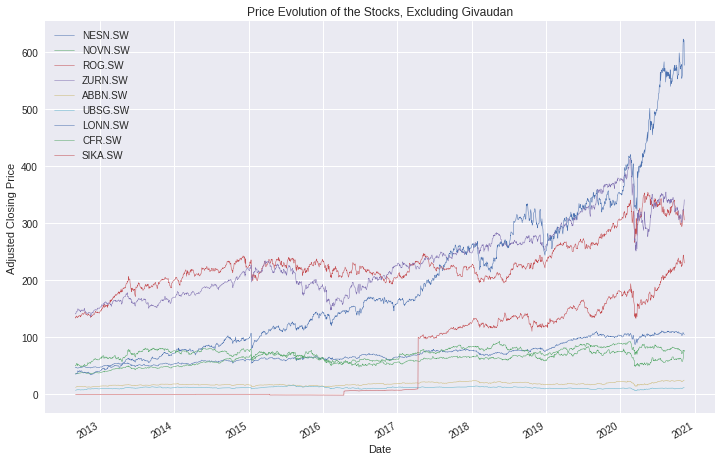

In [242]:
# Define the plot (plot all lines except GIVN.SW and SMI t+1)
ax = df.drop(['SMI t+1', 'GIVN.SW'], axis=1).plot(linewidth=0.5, figsize=(12,8))
# Title
ax.set_title('Price Evolution of the Stocks, Excluding Givaudan')
# ylabel
ax.set_ylabel('Adjusted Closing Price');

Between September 2012 and early 2020, what we can see is a nice general trend of gentle increase for most of our stocks. Others are fairly flat (e.g. UBS and ABB). `SIKA.SW` (Sika AG) was admitted to the **SMI** in 2017, and announced a 1:60 stock split in 2018.

Unsurprisingly, all stocks (including Givaudan) were heavily impacted in early 2020 by the `COVID-19` crisis, which generated a lot of volatility. This may make the job of a predictive model such as the one we aim to build harder than expected, but we'll see that later on.

Let's now also visualize the **SMI** stock price's evolution.

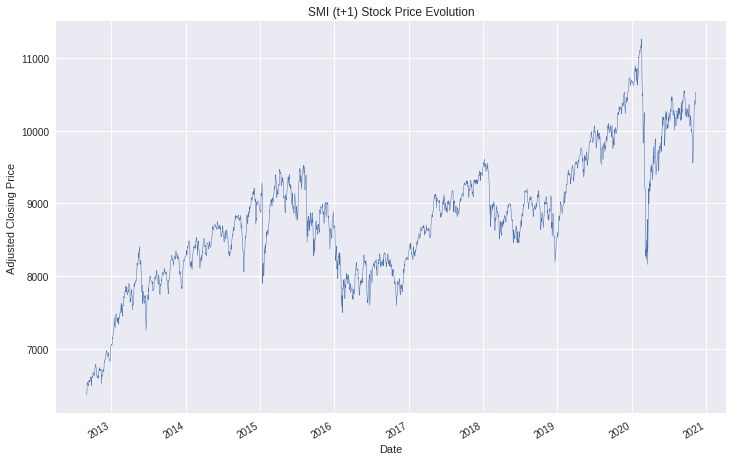

In [243]:
# Define the plot (plot only SMI t+1 line)
ax = df['SMI t+1'].plot(linewidth=0.5, figsize=(12,8))
# Title
ax.set_title('SMI (t+1) Stock Price Evolution')
# ylabel
ax.set_ylabel('Adjusted Closing Price');

This plot suggests that the **SMI** increased overall over our time period, and was also quite volatile. The index was also very much impacted by the **COVID-19** pandemic.

Because our stocks lie in different price ranges, let's create a grid with all stock evolutions so that comparison is facilitated. Before that, we can create a list with the names of the companies in our `DataFrame`, which will allow us to designate them more clearly than by their symbols.

In [244]:
stock_names = ['Nestlé', 'Novartis', 'Hoffmann-La Roche', 'Zurich Insurance Group', 'ABB', 'UBS', 'Lonza', 'Givaudan', 'Richemont', 'Sika', 'SMI t+1']

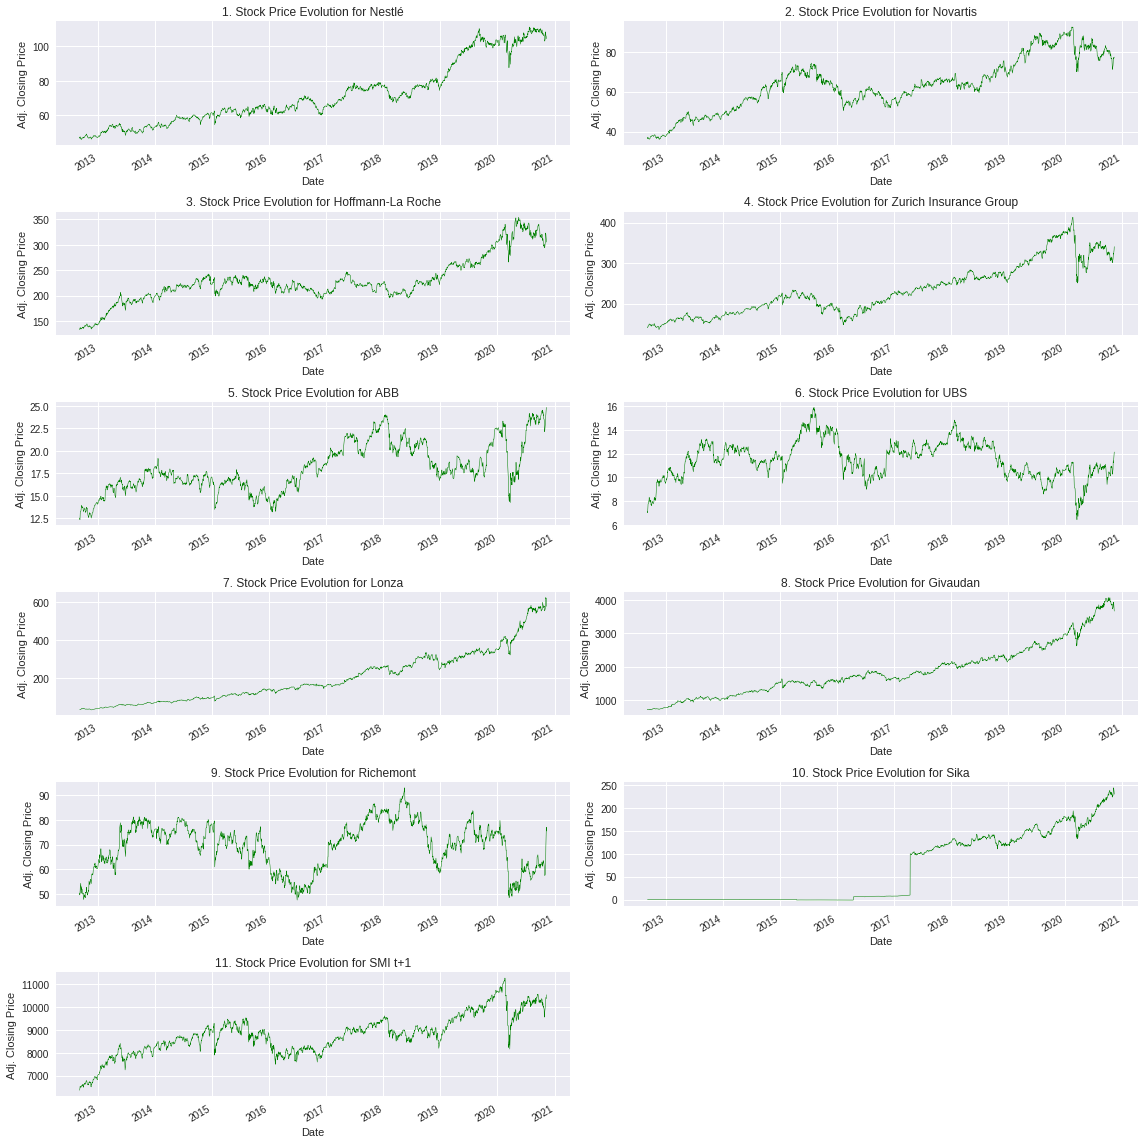

In [245]:
# Select the columns in the DataFrame
df_columns = df.columns

# Loop over the columns
for i, stock in enumerate(df_columns):

  # Create a subplot for each stock (6 rows, 2 columns, index)
  ax = plt.subplot(6, 2, i+1)

  # Plot the stock price
  df[stock].plot(linewidth=0.5, figsize=(16,16), c='Green')

  # Set label
  ax.set_ylabel('Adj. Closing Price')

  # Set title
  ax.set_title(f'{i+1}. Stock Price Evolution for {stock_names[i]}')

  # Adjust the space (padding) between the subplots
  plt.tight_layout()

# Show the final figure containing all subplots
plt.show()

We observe that the evolution of these stocks can be quite dissimilar.

As seen on the vertical axes of the subplots, the price ranges vary between the different stocks. For example, the `UBS` stock price lies in a range between $[6, 16]$, while the `SMI t+1` moves within range $[6'000, 11'500]$. Here is an overview of all of them, including the **SMI**.

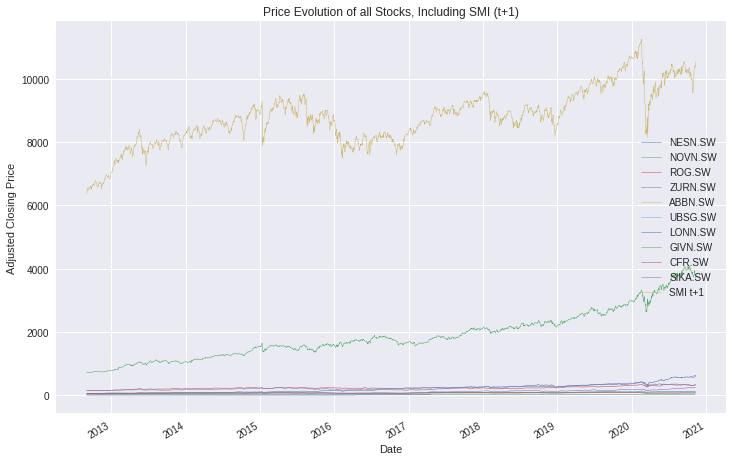

In [246]:
# Define the plot (plot all lines)
ax = df.plot(linewidth=0.5, figsize=(12,8))
# Title
ax.set_title('Price Evolution of all Stocks, Including SMI (t+1)')
# ylabel
ax.set_ylabel('Adjusted Closing Price');

### 3.2 Dataset Pre-Processing

We can now create our target variable $y$, which is the **SMI** stock price for $t + 1$ (this is what our model will attempt to predict on the test data), and our feature variable $X$ which are the daily adjusted closing prices for the 10 stocks we will analyze to predict $y$. We can therefore drop `SMI t+1` from our dataframe to determine $X$.

Also, let's only select the first 2'010 rows of data. We will play around with the remaining rows at the end of the lab, as these correspond to the dates of the HS2020 semester at the HSG. The number of rows we will have left at the end of the lab will be: the initial number of rows (2'052) - the row we dropped earlier (1) - the rows we are selecting now (2'010) = 41.

In [247]:
#Create Feature variable X and Target variable y
X = df[:2010].drop(['SMI t+1'], axis=1)
y = df[:2010]['SMI t+1']

The final step of our pre-processing is to make our train/test split. To understand and evaluate the performance of any trained **supervised machine learning** model, it is good practice to divide the dataset into a **training set** (the fraction of data records solely used for training purposes) and a **evaluation set** (the fraction of data records solely used for evaluation purposes). Please note, the **evaluation set** (also called test set) will never be shown to the model as part of the training process.

<img align="center" style="max-width: 600px; height: auto" src="train_eval_dataset.png">

We set the fraction of testing records to 30% of the original dataset:

In [248]:
eval_fraction = 0.3

Randomly split the dataset into training set and evaluation set using sklearn's train_test_split function:

In [249]:
# Split the data into training set (70%) and test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = eval_fraction, random_state = random_seed)

Evaluate the training set dimensionality:

In [250]:
X_train.shape, y_train.shape

((1407, 10), (1407,))

Evaluate the evaluation set (also called test set) dimensionality:

In [251]:
X_test.shape, y_test.shape

((603, 10), (603,))

### 3.3 Linear Regression Prediction

<img align="center" style="max-width: 600px; height: auto" src="architecture_pipeline.png">

Basic Linear Regression architecture - from a dataset with features and a target variable, find the relationship between the features and the target by considering the target to be a weighted sum of the features. Use that formula to then predict unseen observations.

#### 3.3.1 Theoretical Background

Before we continue with our code, let's (re)visit **Linear Regression** theory, and illustrate it with a small example.

This theoretical explanation is based on:
>- Mathematical notation: Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2020). Dive into Deep Learning. Available at https://d2l.ai/index.html

*Linear Regression* is a relatively straightforward yet popular tool for regression. It is used to model the relationship between one or more independent variables $X$ and a dependent variable $Y$ (in our case, $X=$ several stock prices and $Y=$ the **SMI**). It is often used in Machine Learning to make predictions, as the model outputs continuous (as opposed to discrete) values. It can predict things like asset prices (e.g. stocks), lengths of stay (e.g. for patients in a hospital) or even cosmic distance scale in astrophysics.

Linear Regression is also used as the basis for Logistic Regression, which is used for classification (see our Logistic Regression Lab Tutorial for customer churn prediction).

Linear Regression makes two very important assumptions:
- 1. The relationship between the independent variables $X$ and the dependent variable $Y$ is linear, i.e., $Y$ can be expressed as a weighted sum of the elements in $X$, given some noise on the observations.
- 2. Any noise is well-behaved (following a Gaussian distribution).

Consequently, the main **equation** behind Linear Regression is as follows:

$$ŷ = w_{1}x_{1} + w_{2}x_{2} + ... + w_{d}x_{d} + b$$

Where 
- $ŷ$ is our prediction (e.g. the **SMI** price for the next day)
- $w_{x}$ are weights given to the different features
- $b$ is a bias value (also called the intercept)
- $d$ is the number of features (columns) in our input data (e.g. 10 stock prices)

This means that for each instance of the data (each stock price), we compute $ŷ$, our prediction for the **SMI** price for $t+1$. To calculate $ŷ$, we assign weights to the different features $x$ (stocks) and a bias. This is as simple as a linear equation $y = wx + b$, where we have a slope and an intercept. The only difference is that we call them weights (given to each feature) and the bias.

It is quite intuitive that we must give different weights to the different features because some stocks might have more influence on the **SMI** price for $t+1$ than others.

So given our data, our goal is to find the weights $w_{x}$ and the bias $b$ such that on average, our model's predictions best fit the true prices observed in the data. Models whose output predictions are determined by the affine transformation of input features are linear models, where the affine transformation is specified by the chosen weights and bias. The weights $w_{x}$ and the bias $b$ are called the *parameters* of our model.

We can distinguish several **steps** in the Linear Regression algorithm. Here's an overview:

1. Assign random values to the weights $w$ and the bias $b$.
2. Calculate $ŷ$ given these weights and the bias.
3. Calculate the loss (how far off are these results from the actual values).
4. Compute the gradients for the weights and the bias to know how to adjust the values that we initially set at random.
5. Update the weights and the bias until we get satisfactory results, while avoiding overfitting.

Steps 3 to 5 are done repeatedly until the algorithm gets the desired results.

#### 3.3.2 Loss calculation

We have to start by assigning random values to the weights $w$ and the bias $b$. We will probably get pretty bad results with these random parameters. Our goal is to gradually update them so that they can give us the best chance of predicting our target value $Y$. How can we do that? Well, it starts by finding out how badly we performed. If we can know how far off we were and in what direction, we can use gradient descent to update the parameters by the right amount in the right direction (more on that later). 

The *loss function* quantifies the distance between the real and predicted value of the target. The loss will usually be a non-negative number where smaller values are better and perfect predictions incur a loss of 0. The most popular loss function in regression problems is the squared error. When our prediction for an example $i$ is $ŷ_{i}$ and the corresponding true label (the actual value) is $y_{i}$, the squared error is given by:

$$L_{i}  (w, b) = \frac {1}{2} (y_{i} - ŷ_{i})^2 $$

The constant $\frac {1}{2}$ makes no real difference but will prove notationally convenient, canceling out when we take the derivative of the loss.

The *Mean Square Error*, this loss function on all examples (rows) in our training data, is accordingly defined as:

$$MSE = \frac {1}{N} \sum_{i=1}^N (y_{i} - ŷ_{i})^2$$

<img align="center" style="max-width: 600px; height: auto" src="loss_graph.png">

When training the model, we want to find parameters $w∗$, $b∗$ that minimize the total loss across all training examples:

$$w*, b* = argmin_{\mathbf{w, b}} L(w,b)$$

#### 3.3.3 Updating model parameters

We use an algorithm called **gradient descent** to update our parameters and optimize the model. The parameter-update is meant to reduce our model's loss, hence the importance of accurately calculating it. This is done in an iterative manner - gradient descent consists of taking the derivative of the loss function with regards to the parameters. The result of this derivation will reveal the amplitude and direction of the required adjustment to the parameters.

However, this computation can be really time-consuming if we have to pass over the entire dataset before making a single update. Thus, we will often settle for sampling a random minibatch of examples every time we need to compute the update, a variant called *minibatch stochastic gradient descent*. We randomly choose a minibatch (a certain number of examples from the training data, i.e. dates in our case), and compute the derivative (gradient) of the average loss on the minibatch with regard to the model parameters. 

Because one day's data is different from another's, we must limit the impact the loss on this individual instance has on our parameters (which are shared for all days). To that end,  we adopt a *learning rate η* to scale the gradients to, e.g., a tenth or a thousandth of their value.

<img align="center" style="max-width: 600px; height: auto" src="gradient_descent.png">

This mathematical process can be quite abstract and a lot to take in at once - why don't we go through a small example to understand things better?

#### 3.3.4 Example with steps

For our small example, let us imagine a scenario where we examine the relationship between the number of hours a *HSG* student has worked towards their *Machine Learning* exam, and their grade in said exam. 5 HSG students provide us with the number of hours they worked towards the exam, and their grade. 

$X$ represents the number of hours they studied, and $Y$ the grade they got. Let's say that we have the following table:

<img align="center" style="max-width: 600px; height: auto" src="student_example1.png">

During our calculations, we will only take the **first 4 students** into account. We will keep the last student (last row) to test our results later.

Here is the same information in **Python** code - our datapoints, with which we want to build a **Linear Regression** model:

In [252]:
# Define input variables
hours = [20, 25, 30, 40]
grades = [3.5 ,4, 5, 6]

Visualize the points:

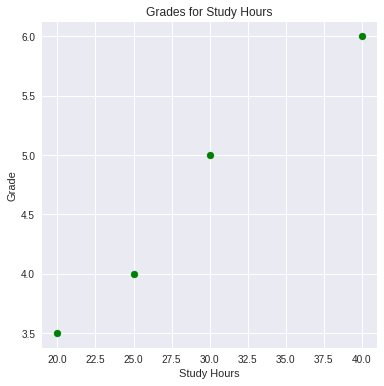

In [253]:
# Define figure size
plt.figure(figsize=(6,6))

# Scatter the variables (grades in relation to study hours)
plt.scatter(hours,grades, c='Green')

# Title
plt.title('Grades for Study Hours')
# xlabel
plt.xlabel('Study Hours')
# ylabel
plt.ylabel('Grade');

We want to find a line that best fits this data, so that future predictions are possible.

**Step 1 - Assign random values to the weight(s) and the bias**

Since we only have one input variable $X$ xhere, we will only use one weight $w$. Let's also give a value to the bias $b$.

Random values: 
- $w = 0.5$
- $b = 0.5$

**Step 2 - Calculate $ŷ$ given these weights and the bias**

$ŷ_{Bert} = 0.5 * 20 + 0.5 = 10.5$

$ŷ_{Urs} = 0.5 * 25 + 0.5 = 13$

$ŷ_{Helvetia} = 0.5 * 30 + 0.5 = 15.5$

$ŷ_{Roger} = 0.5 * 40 + 0.5 = 20.5$

These parameters obviously do not fit our data yet. Bert certainly did not have a grade of 10.5, this is actually pretty far from his real grade, 3.5.

**Step 3 - Calculate the loss**

$MSE = loss =  \frac {1}{N} \sum_{i=1}^N (y_{i} - ŷ_{i})^2 = \frac {1}{N} \sum_{i=1}^N (y_{i} - (w*x_{i} + b))^2$

$loss = \frac {1}{4} [(3.5-10.5)^2 + (4-13)^2 + (5-15.5)^2 + (6-20.5)^2] = 112.625$

**Step 4 - Calculate the gradients**

We must calculate the gradients by taking the derivative of the loss with respect to each of our parameters (weights and bias). These will indicate how much we must change our parameters to reduce the loss and thus get our predicted values closer to the actual ones.

Let's first compute the weight gradient:

$$\frac {∂loss}{∂w}=\frac {1}{N} \sum_{i=1}^N 2*(y_{i} - (w*x_{i} + b))*(-X_{i}) = \frac {-2}{N} \sum_{i=1}^N X_{i}*(y_{i} - ŷ_{i})$$

$$\frac {∂loss}{∂w}= \frac {-2}{4}*[20*(3.5-10.5) + 25*(4-13) + 30*(5-15.5) + 40*(6-20.5)] = 630$$

Now the bias gradient:

$$\frac {∂loss}{b}=\frac {1}{N} \sum_{i=1}^N 2*(y_{i} - (w*x_{i} + b))*(-1) = \frac {-2}{N} \sum_{i=1}^N (y_{i} - ŷ_{i})$$

$$\frac {∂loss}{∂b}= \frac {-2}{4}*[(3.5-10.5) + (4-13) + (5-15.5) + (6-20.5)] = 20.5$$

In our case, the gradients turn out to be positive, so we will have to **decrease** our parameters' values. The gradient of $w$ is larger than that of $b$, which means that the adjustment needed for $w$ is more important. The gradients give us the direction and scope of the change needed.

**Step 5 - Update the weights and the bias**

We now have all we need to update the parameters so that they better fit our data. We will use a *learning rate* $η$ to control the update of our parameter. This avoids overshooting - changing the parameter in the right direction but so far that it is actually worse. Let's say $η = 0.001$.

$w = w - η*\frac {∂loss}{∂w}=0.5-0.001*(630)=-0.13$

$b = b - η*\frac {∂loss}{∂b}=0.5-0.001*(20.5)=0.4795$

This completes the first iteration of our **gradient descent** algorithm. Updating the weights and the bias is an iterative process which will be repeated for either a fixed number of times or until the loss converges.

**Translating this into python code**

Define our data:

In [254]:
# Define input variables x and target variables y
hours = [20, 25, 30, 40]
grades = [3.5 ,4, 5, 6]

# Transpose the data so that x and y become vectors
x = np.array([hours]).transpose()
y = np.array([grades]).transpose()
print(x, '\n\n', y)

[[20]
 [25]
 [30]
 [40]] 

 [[3.5]
 [4. ]
 [5. ]
 [6. ]]


Apply Gradient Descent algorithm:

In [255]:
# Step 1, initialize the parameters
w = 0.5
b = 0.5

# Define learning rate
lr = 0.001
# Define n (number of elements in x)
n = float(len(x))
# Define number of iterations
epochs = 1
# Create empty list for loss
loss = []

# Perform Gradient Descent 
for i in range(epochs): 

    # Step 2
    pred = w*x + b  # The current predicted value of Y
    print('Prediction with randomly initialized parameters:\n', pred)
    
    # Step 3
    indiv_loss = 1/n * sum((y - pred)**2) # The loss of this iteration
    loss.append(indiv_loss)
    print('\nLoss:', loss)

    # Step 4
    w_gradient = (-2/n) * sum(x * (y - pred))  # Derivative wrt w
    print('\nWeight gradient:', w_gradient)
    b_gradient = (-2/n) * sum(y - pred)  # Derivative wrt b
    print('\nBias gradient:', b_gradient)

    # Step 5
    w = w - lr * w_gradient  # Update w
    print('\nNewly updated weight:', w)
    b = b - lr * b_gradient  # Update b
    print('Newly updated bias:', b)

Prediction with randomly initialized parameters:
 [[10.5]
 [13. ]
 [15.5]
 [20.5]]

Loss: [array([112.625])]

Weight gradient: [630.]

Bias gradient: [20.5]

Newly updated weight: [-0.13]
Newly updated bias: [0.4795]


Looks like our math and our code agree! Now let's try this with more than just 1 iteration. Say that we will iterate 100'000 times. Our parameters should get better and better.

In [256]:
# Step 1
w = 0.5
b = 0.5

# Define learning rate
lr = 0.001
# Define n (number of elements in x)
n = float(len(x))
# Define number of iterations
epochs = 100000
# Create empty list for loss
loss = []

# Performing Gradient Descent 
for i in range(epochs): 

    # Step 2
    pred = w*x + b  # The current predicted value of Y
    
    # Step 3
    indiv_loss = 1/n * sum((y - pred)**2)
    loss.append(indiv_loss)

    # Step 4
    w_gradient = (-2/n) * sum(x * (y - pred))  # Derivative wrt w
    b_gradient = (-2/n) * sum(y - pred)  # Derivative wrt b

    # Step 5
    w = w - lr * w_gradient  # Update w
    b = b - lr * b_gradient  # Update b

    # Print updated parameters and predictions every 20'000 iterations
    if (i+1) % 20000 == 0:
      print('Weight at iteration {}: {}'.format(i+1,w))
      print('Bias at iteration {}: {}'.format(i+1,b))
      print('Predictions at iteration {}: {}\n'.format(i+1, pred.transpose()))


print('Updated final weight:', w)
print('Updated final bias:', b)
print('Final predictions:', pred.transpose())

Weight at iteration 20000: [0.12977448]
Bias at iteration 20000: [0.89169792]
Predictions at iteration 20000: [[3.4871859  4.13605904 4.78493218 6.08267846]]

Weight at iteration 40000: [0.1286722]
Bias at iteration 40000: [0.92548285]
Predictions at iteration 40000: [[3.49892667 4.14228773 4.78564878 6.07237088]]

Weight at iteration 60000: [0.12857987]
Bias at iteration 60000: [0.92831273]
Predictions at iteration 60000: [[3.4999101  4.14280945 4.7857088  6.0715075 ]]

Weight at iteration 80000: [0.12857214]
Bias at iteration 80000: [0.92854976]
Predictions at iteration 80000: [[3.49999247 4.14285315 4.78571383 6.07143518]]

Weight at iteration 100000: [0.12857149]
Bias at iteration 100000: [0.92856961]
Predictions at iteration 100000: [[3.49999937 4.14285681 4.78571425 6.07142913]]

Updated final weight: [0.12857149]
Updated final bias: [0.92856961]
Final predictions: [[3.49999937 4.14285681 4.78571425 6.07142913]]


Let's visualize the loss function. If gradient descent did its job correctly, we should see it converging to 0.

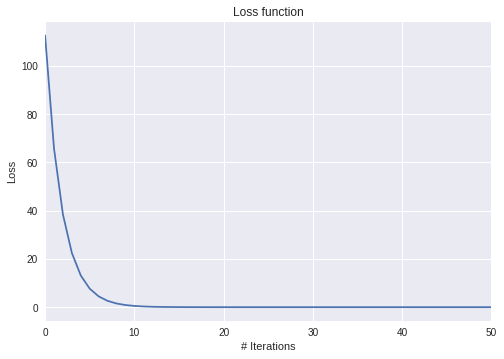

In [257]:
# Title
plt.title('Loss function')
# Name x axis
plt.xlabel('# Iterations')
# Name y axis
plt.ylabel('Loss')
# Plot the loss
plt.plot(loss)
# Set the limit of the x axis to 50 (so that the curve can be nicely seen)
plt.xlim([0,50])

plt.show()

As we can see, the loss dramatically decreases until iteration 15, before flattening for gradual convergence to 0.

As indicated by this fact and by looking at the predictions during the loop, prediction improvement after a certain point starts being negligeable. We could then choose to only train the model on 20'000 or so epochs.

Now, let's see what our regression line looks like!

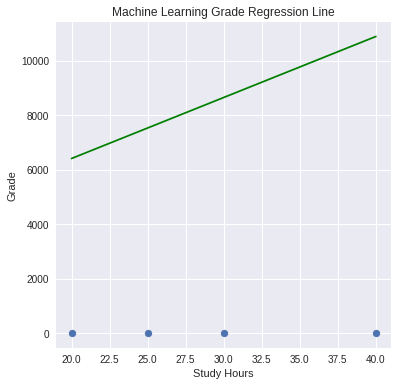

In [286]:
# Define figure size
plt.figure(figsize=(6,6))
# Scatter the variables (grades in relation to study hours)
plt.scatter(x,y)
# Plot regression line
line = plt.plot([min(x), max(x)], [min(pred), max(pred)], color='green')  # regression line
# Title
plt.title('Machine Learning Grade Regression Line')
# Axis labels
plt.xlabel('Study Hours')
plt.ylabel('Grade')

plt.show;

This is the line that **Gradient Descent** found after its iterations. But how did it get there? The following video shows how the line moved from the first iteration to the 40th:

In [259]:
%%HTML
<div align="middle">
<video width="60%" controls>
<source src="linear_regression_movie.mp4" type="video/mp4">
</video></div>

Looks like it fitted our data nicely!

Now, what about Heidi? We totally left her out of our cool model building. However, we can now see how well our model and its updated parameters could predict her grade!

<img align="center" style="max-width: 600px; height: auto" src="student_example2.png">

$$ŷ_{Heidi} = w*x_{Heidi} + b = 0.12857149*35 + 0.92856961 = 5.42857176$$

Our model gives a grade of 5.43 to Heidi based on her grade. That is really close to her actual grade of 5.5! Of course, this example was quite simple as there was only one input variable, and a fairly linear relationship.

**Ordinary Least Squares (OLS)**

To verify how accurate our **Gradient Descent**-based model was, we can use a second method that solves the regression problem. The OLS method rewrites the regression equation in matrix form, and then minimizes the sum of the residual error terms.

$$Y = X'β + Ɛ$$

$β$ is the matrix that contains all regressors (parameters).

Capital letters denote matrices - so all variables in this equation are matrices. OLS's goal is to minimize $Ɛ$ (the error term). The final OLS equation looks as follows:

$$β^* = (X'X)^{-1}X'y$$

The problem with this method is that it is computationally very intensive, and thus does not perform well on large datasets. It can however work here for our very small example, so let's see what values it gives us for the parameters:

In [260]:
# OLS
# Do not worry about the code
hours = [20, 25, 30, 40]
grades = [3.5 ,4, 5, 6]
X = np.array([[1,1,1,1],hours]).transpose()
y = np.array([grades]).transpose()

theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.transpose(), X)), X.transpose()), y)

print(theta)

[[0.92857143]
 [0.12857143]]


Great! That is almost identical. We can conclude that with enough iterations, **Gradient Descent** manages to find good parameter values for our data.

### 3.4 Regression on the Swiss stocks dataset

Now that we have understood what goes when applying Linear Regression with Gradient Descent, let's apply that to our Swiss stocks data!

Luckily, the `Scikit-Learn` (https://scikit-learn.org) machine learning library provides a variety of machine learning algorithms that can be easily interfaced using the Python programming language. Among others the library also contains the **Linear Regression** algorithm. Linear Regression can be trained "off-the-shelf" to solve the mathematical task formulated above. Let's instantiate a Linear Regression model:

In [261]:
# Instantiate the model
model = LinearRegression()

Train or fit the Linear Regression model using the training dataset:

In [262]:
# Fit the Linear Regression Model
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

To clarify: we have randomly taken some rows (dates) from the `df` dataset for training and have shown these to the algorithm. It has tried to find a relationship between the stock prices `X_train` and the corresponding **SMI** price for the next day (which shared the same row) `y_train`, for these rows we have selected for training. More specifically, it has found specific weights to give to the different input features $X$ (the stocks) and a bias value $b$.

We can already see what parameters our model has found:

In [263]:
# Weights given to the different features
print('Weights:',model.coef_)

# Bias (intercept)
print('\nBias:', model.intercept_)

Weights: [12.36140476 24.87295503  9.49115465  3.27557664 44.58408512 68.66617706
 -0.85504089 -0.34716363 11.54915746 -0.33383032]

Bias: 1814.3988310945624


Now that the algorithm has been trained on the data and that we have the resulting parameters, we can re-write the **Linear Regression Equation** using them! This gives:

$$SMI_{t+1} = (12.361*X_{Nestlé}) + (24.873*X_{Novartis}) + (9.491*X_{Hoffmann-La Roche}) + (3.276*X_{Zurich Insurance Group}) + (44.584*X_{ABB}) + (68.666*X_{UBS}) + ((-0.855)*X_{Lonza}) + ((-0.347)*X_{Givaudan}) + (11.549*X_{Richemont}) + ((-0.334)*X_{Sika}) + 1814.399$$

Our model says that this equation is the best to predict the **SMI** price for the next day. Interestingly, we can observe the different weights given to the different stocks. We can see, for example, that the weight given to `UBS` is far greater than that of, say, `Givaudan`. This may be because the model thinks `UBS` is a better predictor of the `SMI t+1`, but it can also simply be because `UBS` has a much smaller average adjusted closing price! A higher weight thus does not necessarily give it more importance, it may simply give the stock the same relative importance as other stocks, by compensating its lower price. Of course, even in relative terms, the model will give features different weights because some actually *are* better predictors than others.

This equation, with our algorithm's computed parameters, is the model that has been learned and that can therefore be used for inference.

The next part will be about showing `X_test` to the algorithm (i.e. the stock prices for the days it has not yet seen), and make it predict what the **SMI** stock price for $t + 1$ might be, based on the "knowledge" is has gained while training. These predictions will be compared to the actual values `y_test` to evaluate the model.

## 4. Evaluation

After fitting the training data, the optimal values chosen by the Linear Regression model can then be used to predict the prices of so far unseen observations. We will utilize the trained model to predict the prices of the remaining observations contained in the evaluation dataset:

In [264]:
# Predict the value for new, unseen data
pred = model.predict(X_test)

### 4.1 Metrics and visualizations

Unlike for classification tasks, we cannot use accuracy as a metric to evaluate our model. Usually, very few to none of the individual predictions exactly match their true values. We thus have to use **Error-based** metrics to evaluate our model. The three metrics we will use are:
>- Mean Absolute Error (MAE)
>- Mean Squared Error (MSE)
>- $R^2$ score

The **MAE** simply represents the average absolute error of our predictions. It is given by the following formula:

$$MAE = \frac {1}{N} \sum_{i = 1}^N |y_{i} - ŷ_{i}|$$

The **MSE** takes the **squared** difference between actual and predicted values. These differences are then summed up and averaged over the number of samples $N$. As stated previously, the **MSE** is given by:

$$MSE = \frac {1}{N} \sum_{i=1}^N (y_{i} - ŷ_{i})^2$$

Why do we use both the **MAE** and the **MSE**? In the end, they both originate from the mean differences between actual and predicted values. However, the **MSE** grows quadratically with each residual, while the **MAE** only grows linearly. Here lies the utility of the **MSE** - it is much more sensitive to outliers (predictions that largely deviate from their true value) which are more strongly penalized. This is why **MSE** is used to determine the extent to which the model fits the data. Also, this difference in growth between **MAE** and **MSE** (linear vs. quadratic) means that the **MSE** will always be larger.

The $R^2$ score, also called the *coefficient of determination*, is a measure of the global fit of the model. Its value lies between $[0,1]$ and represents the proportion of variability in $y_{i}$ that may be attributed to some linear combination of the regressors (features) $X_{i}$. An $R^2$ score of $1$ means that the trained model is able to explain all the variability in $y_{i}$, while $R^2 = 0$ indicates the absence of a linear relationship. Remember: $R^2$ is a measure of correlation, not causation.

$R^2$ is given by:

$$R^2 = 1 - \frac {\sum_{i=1}^N (y_{i} - ŷ_{i})^2}{\sum_{i=1}^N (y_{i} - Ῡ)^2}$$

where Ῡ is the **mean** of our data, given by:

$$ Ῡ = \sum_{i=1}^N y_{i}$$


Now let's see how big our MAE and MSE are, and what our $R^2$ score looks like.

In [265]:
# Model evaluation for testing set

# The mean absolute error
mae = metrics.mean_absolute_error(y_test, pred)

# The mean squared error
mse = metrics.mean_squared_error(y_test, pred)

# The coefficient of determination: 1 is perfect prediction. This is the r^2 score
r2 = metrics.r2_score(y_test, pred)

print('Mean Absolute Error is: {}'.format(mae))
print('\nMean Squared Error is:  {}'.format(mse))
print('\nR2 score is:            {}'.format(r2))

Mean Absolute Error is: 104.35439211146202

Mean Squared Error is:  20855.04577655326

R2 score is:            0.9682333018573245


Ok. Let's think about what these results mean. 

>- The **MAE** means that on average, our model's predictions were off by $104.35$ CHF. Considering the **SMI** stock price started above at 6'000 and increased to above 10'000 with our timeframe, that error corresponds to $0.01$% to $0.0167$%. Not too bad, but we could probably get better results with more comprehensive and complex models.
>- The **MSE** means that on average, the square error of our predicted values was $20'855.05$. This is above the square of the **MAE** ($104.35^2= 10'888.92$). This tells us that there were some errors worth more than the **MAE** (to be expected), and the **MSE** punishes these. It is very sensitive to outliers, as the *square error* is exponential by definition. Without comparison to other models on the same data, these results are difficult to interpret. However, the **MSE** does not seem too extreme, meaning the data is dispersed somewhat closely to its mean (the regression line).
>- The $R^2$ is probably the most important metric to evaluate our prediction results. It is a measure of correlation, where $R^2=1$ indicates perfect correlation and the line thus perfectly fits the data. Our $R^2$ result is not $1$, but very close! $R^2=0.968$ means that there exists a linear relationship, and that it is quite good because the high correlation allows us to make decent, relevant predictions. $96.8$% of the variance in the dependent variable (`SMI t+1`) can be explained by the independent variables (the 10 stocks).

To examine further, we can compare our predictions $ŷ_{i}$ with the actual values $y_{i}$ in a DataFrame. We can also add, for each prediction, the **absolute** error and the **squared** error. Let's call this DataFrame `results`:

In [266]:
# For each prediction, calculate absolute error and append it to a list
ae_list = []
for i in range(len(y_test)):
  ae = np.abs(y_test[i]-pred[i]) # np.abs -> absolute value
  ae_list.append(ae)

# For each prediction, calculate squared error and append it to a list
se_list = []
for i in range(len(y_test)):
  se = (y_test[i]-pred[i])**2
  se_list.append(se)

# Create the results DataFrame with the actual values y, the SMI stock prices for the next day
results = pd.DataFrame(y_test)

# Add a new column "Pred" to it with our predictions
results['Pred'] = pred

# Add a new column "Absolute Error" to it with our absolute errors
results['Absolute Error'] = ae_list

# Add a new column "Squared Error" to it with our squared errors
results['Squared Error'] = se_list

# Show the first 20 rows
results.head(20)

,SMI t+1,Pred,Absolute Error,Squared Error
Date,,,,
2017-06-14,8853.009766,8978.746680,125.736914,15809.771547
2014-10-13,8338.009766,8375.717252,37.707487,1421.854550
2014-04-01,8508.259766,8474.035561,34.224204,1171.296171
2018-04-11,8774.759766,8866.901677,92.141911,8490.131802
2014-06-02,8661.200195,8686.963735,25.763540,663.759975
2014-12-22,9021.669922,8904.026471,117.643451,13839.981613
2017-07-05,8886.950195,9022.254914,135.304719,18307.366922
2014-05-26,8710.379883,8707.098839,3.281044,10.765249
2015-02-17,8800.709961,8578.488455,222.221506,49382.397515


Finally, let's also plot our predictions against the actual values! In a perfect world, our predictions and actual values would be spread on one line with no deviations. Of course, this is not the case. If simple Machine Learning models could perfectly and easily predict stock market values, we would know it.

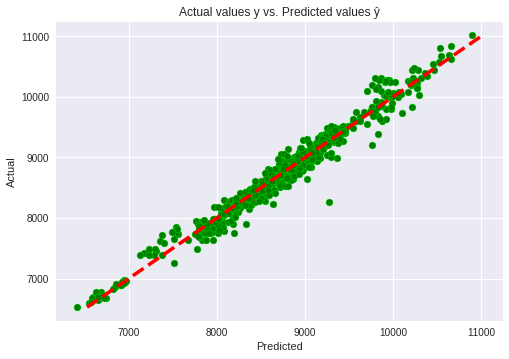

In [267]:
# Define figure
fig, ax = plt.subplots()

# Scatter our predictions vs actual values and define colors
ax.scatter(pred, y_test, c = 'Green', edgecolors=(0, 1, 0))

# Plot the red line
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3.5)

# Plot title
ax.set_title('Actual values y vs. Predicted values ŷ')

# Title of the X axis
ax.set_xlabel('Predicted')

# Title of the Y axis
ax.set_ylabel('Actual')

plt.show()

As showed by the plot, most points are rather close to the diagonal line - we only have very few points that substantially deviate from it (outliers). This would indicate a rather high $R^2$ score, which is the case!

### 4.2 Stock market positions this semester

We built a Linear Regression model that aims at predicting the **SMI** for the next day, based on the values of 10 Swiss stocks on the current day. We do not want to have done all of that for nothing, do we? To get some use out of the model, let's see how we would have performed on our **SMI** positions during this semester! Let's take the last rows from the dataset (which we did not use yet) and predict the corrensponding **SMI t+1** stock prices. We can then compare these predictions with the actual values and check whether our daily long/short positions would have actually been successful!

Let's first define our input data and the target variable. We shall call them `X_rest` and `y_rest` to signal we are working with the rest of our dataset (the last 41 rows).

This corresponds to the timeframe from September 14th, 2020 (the start of HS2020 at **HSG**) and November 10th, 2020.

In [268]:
#Create Feature variable X and Target variable y from the rest of the dataset (yet unused data)
X_rest = df[2010:].drop(['SMI t+1'], axis=1)
y_rest = df[2010:]['SMI t+1']

Examine our input data:

In [269]:
X_rest

,NESN.SW,NOVN.SW,ROG.SW,ZURN.SW,ABBN.SW,UBSG.SW,LONN.SW,GIVN.SW,CFR.SW,SIKA.SW
Date,,,,,,,,,,
2020-09-14,109.699997,81.900002,330.000000,340.500000,23.780001,11.116201,550.599976,3963.0,65.541504,217.000000
2020-09-15,109.639999,83.059998,335.450012,342.000000,23.799999,10.887652,557.400024,4010.0,65.639999,219.100006
2020-09-16,110.260002,82.269997,337.149994,344.899994,23.920000,10.950869,559.799988,4052.0,65.900002,220.100006
2020-09-17,109.400002,82.300003,336.899994,341.000000,23.700001,10.843888,563.000000,4058.0,65.040001,222.600006
2020-09-21,108.419998,81.580002,338.000000,331.399994,22.920000,10.022087,572.000000,4050.0,61.419998,217.100006
2020-09-22,109.199997,81.669998,340.350006,329.200012,23.080000,10.002636,569.400024,4009.0,61.380001,217.800003
2020-09-23,109.059998,81.309998,334.299988,328.299988,23.240000,9.929695,576.400024,4006.0,61.619999,223.199997
2020-09-24,108.220001,80.199997,331.799988,321.899994,23.120001,9.700174,566.400024,3968.0,60.840000,220.699997
2020-09-25,109.760002,80.309998,330.950012,319.100006,23.160000,9.412301,568.799988,3942.0,60.599998,221.699997


Evaluate dimensionality:

In [270]:
X_rest.shape, y_rest.shape

((41, 10), (41,))

#### 4.2.1 Predictions for Autumn Semester 2020

Make predictions:

In [271]:
# Predict the value for new, unseen data
pred_rest = model.predict(X_rest)

On this particular subset of recent data, these are our results:

In [272]:
# Model evaluation for testing set

# The mean absolute error
mae_rest = metrics.mean_absolute_error(y_rest, pred_rest)

# The mean squared error
mse_rest = metrics.mean_squared_error(y_rest, pred_rest)

# The coefficient of determination: 1 is perfect prediction. This is the r^2 score
r2_rest = metrics.r2_score(y_rest, pred_rest)

print('Mean Absolute Error is: {}'.format(mae_rest))
print('\nMean Squared Error is:  {}'.format(mse_rest))
print('\nR2 score is:            {}'.format(r2_rest))

Mean Absolute Error is: 470.48225271108106

Mean Squared Error is:  232937.44657010198

R2 score is:            -2.9507478377803746


Ouch. The metrics are really bad. Remember that stocks are extremely volatile and subject to unpredictable events during the **COVID-19** crisis. With this kind of model performance, we might not get the best daily long/short positions.

As we did before, we can start by comparing our predictions with the actual **SMI** values, while also computing the average and squared error for each prediction:

In [273]:
# For each prediction, calculate absolute error and append it to a list
ae_list_rest = []
for i in range(len(y_rest)):
  ae_rest = np.abs(y_rest[i]-pred_rest[i]) # np.abs -> absolute value
  ae_list_rest.append(ae_rest)

# For each prediction, calculate squared error and append it to a list
se_list_rest = []
for i in range(len(y_rest)):
  se_rest = (y_rest[i]-pred_rest[i])**2
  se_list_rest.append(se_rest)

# Create the results_rest DataFrame with the actual values y_rest, the SMI stock prices for the next day
results_rest = pd.DataFrame(y_rest)

# Add a new column "Pred for HS2020" to it with our predictions
results_rest['Pred for HS2020'] = pred_rest

# Add a new column "Absolute Error" to it with our absolute errors
results_rest['Absolute Error'] = ae_list_rest

# Add a new column "Squared Error" to it with our squared errors
results_rest['Squared Error'] = se_list_rest

# Show the first 20 rows
results_rest.head(20)

,SMI t+1,Pred for HS2020,Absolute Error,Squared Error
Date,,,,
2020-09-14,10520.000000,10116.384467,403.615533,162905.498430
2020-09-15,10552.040039,10164.639130,387.400909,150079.464193
2020-09-16,10519.330078,10174.014498,345.315580,119242.849702
2020-09-17,10539.169922,10116.242134,422.927788,178867.913931
2020-09-21,10355.570312,9929.118593,426.451719,181861.068769
2020-09-22,10330.059570,9977.656004,352.403566,124188.273441
2020-09-23,10211.530273,9904.751553,306.778721,94113.183386
2020-09-24,10216.280273,9814.525981,401.754292,161406.511215
2020-09-25,10308.669922,9804.944474,503.725448,253739.326469


Let's again plot our predictions versus the actual values:

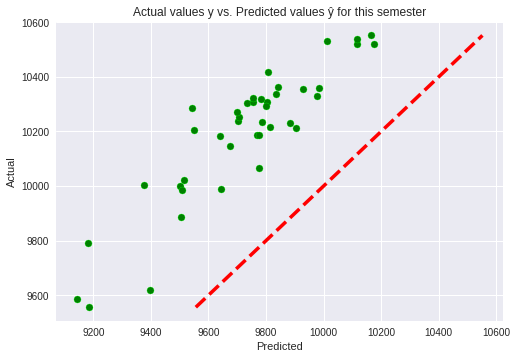

In [274]:
# Define figure
fig, ax = plt.subplots()

# Scatter our predictions vs actual values and define colors
ax.scatter(pred_rest, y_rest, c = 'Green', edgecolors=(0, 1, 0))

# Plot the red line
ax.plot([y_rest.min(), y_rest.max()], [y_rest.min(), y_rest.max()], 'r--', lw=3.5)

# Plot title
ax.set_title('Actual values y vs. Predicted values ŷ for this semester')

# Title of the X axis
ax.set_xlabel('Predicted')

# Title of the Y axis
ax.set_ylabel('Actual')

plt.show()

The predictions are actually much lower than the **SMI** values. Our regression line is way off.

#### 4.2.2 Model's market positions

Now, using simple `for` loops, let's translate that data into movements. When the **SMI** *increases* from day $t$ to day $t+1$, we will append "Up" to a list of daily movements. Otherwise, we will append "Down". We will do this for both the actual and the predicted **SMI** values.

In [275]:
# Create empty list of real movements
real_movements = []

# Loop over the length of the real values (41) but substract 1 as we only have 40 movements
for i in range(len(y_rest)-1):

  # Append 'Up' to our list if the stock price increases
  if y_rest[i+1] >= y_rest[i]:
    real_movements.append('Up')

  # Append 'Down' to our list if the stock price decreases
  else:
    real_movements.append('Down')

# Create empty list of predicted movements
predicted_movements = []

# Loop over the length of the predicted values (41) but substract 1 as we only have 40 movements
for i in range(len(pred_rest)-1):

  # Append 'Up' to our list if the predicted stock price increases
  if pred_rest[i+1] >= pred_rest[i]:
    predicted_movements.append('Up')

  # Append 'Down' to our list if the predicted stock price decreases
  else:
    predicted_movements.append('Down')

In [276]:
print('Real movements:', np.array(real_movements))
print('\nPredicted movements:', np.array(predicted_movements))

Real movements: ['Up' 'Down' 'Up' 'Down' 'Down' 'Down' 'Up' 'Up' 'Down' 'Down' 'Up' 'Up'
 'Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Down' 'Down' 'Down' 'Up' 'Down' 'Down'
 'Down' 'Up' 'Up' 'Down' 'Down' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up'
 'Up' 'Up' 'Down' 'Up']

Predicted movements: ['Up' 'Up' 'Down' 'Down' 'Up' 'Down' 'Down' 'Down' 'Up' 'Down' 'Down' 'Up'
 'Up' 'Up' 'Down' 'Down' 'Up' 'Up' 'Down' 'Down' 'Down' 'Down' 'Up' 'Up'
 'Down' 'Down' 'Up' 'Down' 'Down' 'Down' 'Down' 'Down' 'Up' 'Up' 'Up' 'Up'
 'Down' 'Up' 'Up' 'Up']


Now that we have our movements, we can imagine that each time our predicted stock value goes `Up`, we would have entered a *long* position and if it goes `Down`, we would have taken a *short* position to sell our stock.

Now let's see how many times these positions would have been correct, by comparing our predicted list with the actual movements.

In [277]:
# Initialize the value of our correct positions
correct_positions = 0

# Loop over then length of our real movements list
for i in range(len(real_movements)):

  # Add 1 to our correct positions if the value of our predicted movements equals the value of the real movements
  # e.g. if 'Up' == 'Up' or 'Down' == 'Down'
  if real_movements[i] == predicted_movements[i]:
    correct_positions += 1

  # Do nothing (do not increase count) if the position is not the same
  else:
    pass

print('Number of correct positions:', correct_positions, '\n')
print('As a percentage of all movements:', round(correct_positions/(len(real_movements))*100, 3), '%')

Number of correct positions: 24 

As a percentage of all movements: 60.0 %


As you can see, this little market position experiment is actually a binary classification exercise. We use our regression model to classify movements between `Up` and `Down`. Pretty cool right?

Let's see if `sklearn`'s *accuracy* metric agrees with us, before creating a small confusion matrix.

In [278]:
accuracy = round(metrics.accuracy_score(real_movements, predicted_movements) * 100, 2)
print(f'Classification accuracy: {accuracy} %')

Classification accuracy: 60.0 %


What do we need to verify in order to assess this accuracy score?

We must verify the balance of the target data. If there are $90$% of samples belonging to the `Up` class and we build a naive classifier which classifies all test samples as going up, we will get $90$% accuracy, which does not really reflect our bad classifier.

Verify how many instances of the `real_movements` belong to the `Up` class:

In [279]:
# Count how many times the real movement was Up
n_ups = real_movements.count('Up')

print(f'Number of times the movement is upward: {n_ups}')
print(f'As a percentage of all movements: {n_ups/len(real_movements)*100}%')

Number of times the movement is upward: 21
As a percentage of all movements: 52.5%


We shall thus take this value as our benchmark to interpret accuracy. Let's now also plot a confusion matrix:

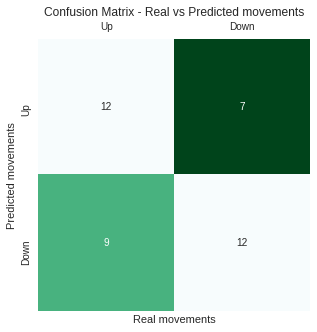

In [280]:
# Define labels (classes)
labels=['Up', 'Down']

# Confusion matrix
mat = confusion_matrix(real_movements, predicted_movements, labels)

# Init the plot
plt.figure(figsize=(5, 5))

# Plot confusion matrix heatmap
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn_r')

# Set ticks
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Choose where to display our ticks
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# Add plot axis labels
plt.xlabel('Real movements')
plt.ylabel('Predicted movements')

# Add plot title
plt.title('Confusion Matrix - Real vs Predicted movements')

plt.show()

If we consider `Up` to be the positive class and `Down` to be the negative one, the matrix shows that we have:
>- 12 True Positives
>- 7 False Positives (Movements incorrectly classified as `Up`)
>- 9 False Negatives (Movements incorrectly classified as `Down`)
>- 12 True Negatives

To summarise, only $60$% of our market positions would have been successful - this is only a bit better than random, given our benchmark of $52.5$%, and the number of samples was very small. We had more False Negatives than False Positives (although the number of samples is too small to draw any meaningful conclusions). Had markets behaved more normally, (i.e. no COVID-19 pandemic), maybe our model would have done better, as indicated by the metrics on our original **test** set. However, our model cannot beat these unpredictable market conditions. And of course, we would want to know more than just the direction the stock is going in.

<img align="center" style="max-width: 500px; height: auto" src="stonks.png">

## 5. Exercises

We recommend you to try the following exercises as part of the lab:

**1. Try different evaluation fractions on the dataset, and have a look at the differences in results.**

Write a Python loop in which you fit and predict the data with the Linear Regression algorithm for different values of the `eval_fraction`. For each iteration, print the MSE, MAE and $r^2$ result. You can for instance try to set the evaluation fraction to 0.1, 0.2, 0.3, 0.4, 0.5, 0.6 and 0.7.

In [287]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

Eval fraction = 0.1 - Mean Absolute Error is: 96.72920078501181
Eval fraction = 0.1 - Mean Squared Error is:  16983.01132680035
Eval fraction = 0.1 - R2 score is:            0.9751279900838549

Eval fraction = 0.2 - Mean Absolute Error is: 93.25974912643795
Eval fraction = 0.2 - Mean Squared Error is:  15744.131306714513
Eval fraction = 0.2 - R2 score is:            0.9768554192625017

Eval fraction = 0.3 - Mean Absolute Error is: 98.5445881630185
Eval fraction = 0.3 - Mean Squared Error is:  17573.7117914776
Eval fraction = 0.3 - R2 score is:            0.9748627033176038

Eval fraction = 0.4 - Mean Absolute Error is: 98.68037295665324
Eval fraction = 0.4 - Mean Squared Error is:  17558.447563143985
Eval fraction = 0.4 - R2 score is:            0.9745782715953257

Eval fraction = 0.5 - Mean Absolute Error is: 100.12819907552382
Eval fraction = 0.5 - Mean Squared Error is:  17762.686337749605
Eval fraction = 0.5 - R2 score is:            0.975217102551242

Eval fraction = 0.6 - Mean Ab

**2. Implement Linear Regression manually using the *Gradient Descent* algorithm**.

Use Python to apply Linear Regression to the following data:

>- Features (input variables) are the number of hours spent at the *Trischli* club in a month: 0 for the first student, 4 for the second, 6 for the third and 10 for the last.

>- The labels (target variables) represent the amount of money spent there in the month: 0, 75, 175 and 250 respectively.

Said differently, `X = [0, 4, 6, 10]` and `y = [0, 75, 175, 250]`

You can use the code from the example presented in this lab to perform Gradient Descent-based Linear Regression. Don't hesitate to play around with the number of epochs, parameter initialization, learning rate etc. You can add code cells if you need them with Ctrl + M B or by clicking the `+ Code` button. 

In [288]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

Updated final weight: [25.96153846]
Updated final bias: [-4.80769231]
Final predictions: [[ -4.80769231  99.03846154 150.96153846 254.80769231]]


If implemented correctly, your parameters should converge to $w = 25.96$ and $b = -4.81$.

## 6. Lab Summary

In this lab, a step by step introduction into **Linear Regression** is presented. The code and exercises presented in this lab may serves as a starting point for more complex and tailored programs.

You may want to execute the content of your lab outside of the Jupyter notebook environment, e.g. on a compute node or a server. The cell below converts the lab notebook into a standalone and executable python script. Pls. note that to convert the notebook, you need to install Python's **nbconvert** library and its extensions:

In [284]:
# installing the nbconvert library
!pip install nbconvert
!pip install jupyter_contrib_nbextensions

Let's now convert the Jupyter notebook into a plain Python script:

In [285]:
!jupyter nbconvert --to script aiml_lab_08.ipynb

[NbConvertApp] WARNING | pattern u'aiml_lab_08.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
    Run n

## 7. References

>- Notation for theory: https://d2l.ai/index.html
>- Gradient Descent implementation: https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931
>- OLS: https://aiaspirant.com/multiple-linear-regression/
>- Evaluation: https://www.datacourses.com/evaluation-of-regression-models-in-scikit-learn-846/